
# Model 3 training ($E_{cm} = 300$ GeV)


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall

In [19]:
drive_dir = Path('/content/drive/MyDrive/Jet_classification_project/Training_Datasets_Models_Results')

jet_images_path = drive_dir / 'Dataset3_75k_300GeV/jet_images.npy'
jet_labels_path = drive_dir / 'Dataset3_75k_300GeV/jet_labels.npy'

model_save_path = drive_dir / 'Dataset3_Model_and_Results/Model3_300GeV.keras'

metrics_path = drive_dir / 'Dataset3_Model_and_Results'

In [20]:
X = np.load(jet_images_path)
y = np.load(jet_labels_path)

if len(X.shape) == 3:
    X = X[..., np.newaxis]

input_shape = X.shape[1:]

print(f"Loaded {X.shape[0]} jet images with shape {input_shape} and {len(np.unique(y))} classes.")
print(f"Labels shape: {y.shape}\n")

print(f"Final Images shape: {X.shape}")
print(f"Pixel Intensity Range: Min = {X.min()}, Max = {X.max()}")

Loaded 237401 jet images with shape (32, 32, 1) and 2 classes.
Labels shape: (237401,)

Final Images shape: (237401, 32, 32, 1)
Pixel Intensity Range: Min = 0.0, Max = 1.0


In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=31, stratify=y)

print(f"Train set:      {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

Train set:      166180 samples
Validation set: 71221 samples


In [22]:
model = models.Sequential()

model.add(layers.Input(shape=input_shape))

model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 504,065 (1.92 MB)

 Trainable params: 503,361 (1.92 MB)

 Non-trainable params: 704 (2.75 KB)

In [23]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=1500,
    decay_rate=0.95)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

model.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])

print("\nModel Compiled Successfully!\n")

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True)

batch_size = 64
epochs = 120

history = model.fit(X_train, y_train,
                     epochs=epochs,
                     batch_size=batch_size,
                     validation_data=(X_val, y_val),
                     class_weight=class_weights_dict,
                     callbacks=[early_stopping, checkpoint])

print(f"\nModel saved to {model_save_path}")

Class Weights: {0: np.float64(1.1126585160089453), 1: np.float64(0.9080576593117166)}

Model Compiled Successfully!

Epoch 1/120
2597/2597 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - accuracy: 0.8652 - auc: 0.9250 - loss: 0.3325 - precision: 0.8775 - recall: 0.8722 - val_accuracy: 0.9537 - val_auc: 0.9893 - val_loss: 0.1272 - val_precision: 0.9532 - val_recall: 0.9633
Epoch 2/120
2597/2597 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9558 - auc: 0.9887 - loss: 0.1272 - precision: 0.9573 - recall: 0.9628 - val_accuracy: 0.9650 - val_auc: 0.9930 - val_loss: 0.0982 - val_precision: 0.9694 - val_recall: 0.9671
Epoch 3/120
2597/2597 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9651 - auc: 0.9925 - loss: 0.1008 - precision: 0.9672 - recall: 0.9696 - val_accuracy: 0.9694 - val_auc: 0.9943 - val_loss: 0.0858 - val_precision: 0.9716 - val_recall: 0.9728
Epoch 4/120
2597/2597 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9693 - auc: 0.9940 - loss: 0.0887 - precision: 0.9701 - recall: 0.9741 - v

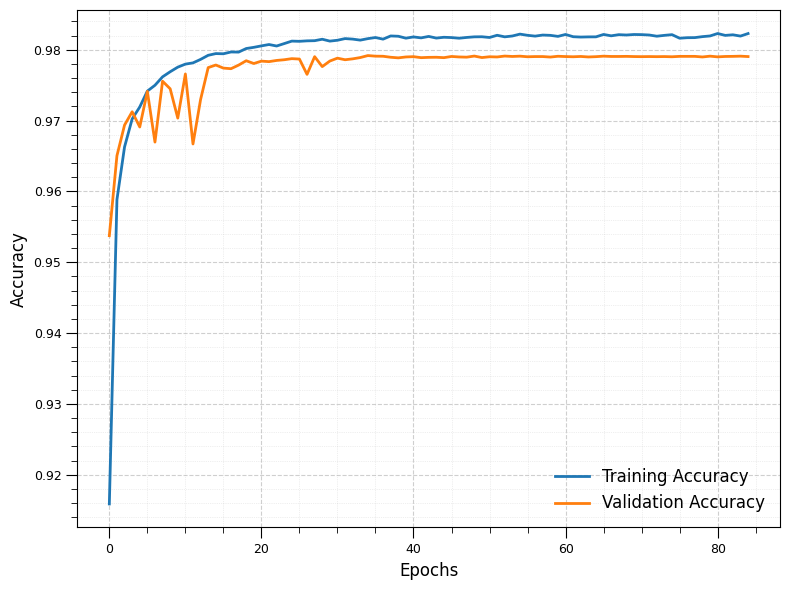

In [24]:
# Accuracy Plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', lw=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', lw=2)

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.minorticks_on()

plt.tick_params(axis='both', which='major', length=8)
plt.tick_params(axis='both', which='minor', length=4)

plt.grid(True, which='major', linestyle='--', linewidth=0.8, alpha=0.6)
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)

plt.legend(loc='best', fontsize=12, frameon=False)
plt.tight_layout()

plt.savefig(f'{metrics_path}/training_vs_val_acc.png', dpi=300)
plt.show()

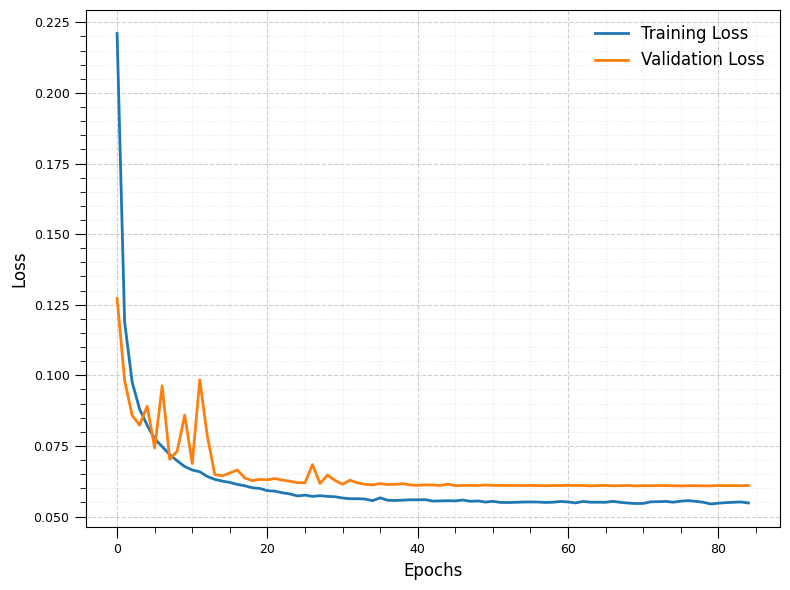

In [25]:
# Loss Plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', lw=2)
plt.plot(history.history['val_loss'], label='Validation Loss', lw=2)

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.minorticks_on()

plt.tick_params(axis='both', which='major', length=8)
plt.tick_params(axis='both', which='minor', length=4)

plt.grid(True, which='major', linestyle='--', linewidth=0.8, alpha=0.6)
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)

plt.legend(loc='best', fontsize=12, frameon=False)
plt.tight_layout()

plt.savefig(f'{metrics_path}/training_vs_val_loss.png', dpi=300)
plt.show()

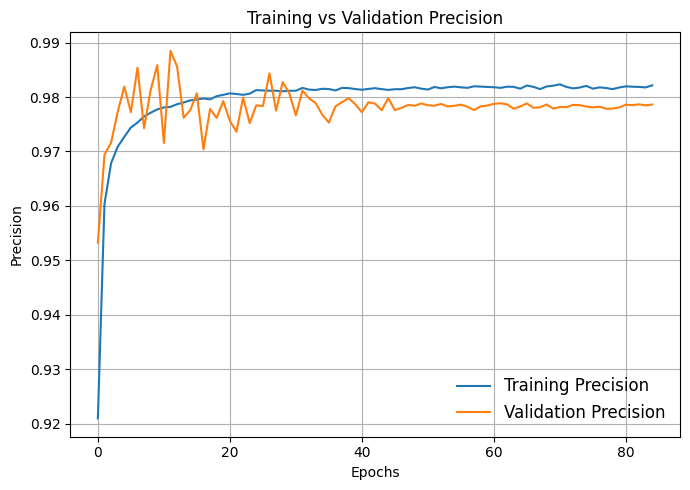

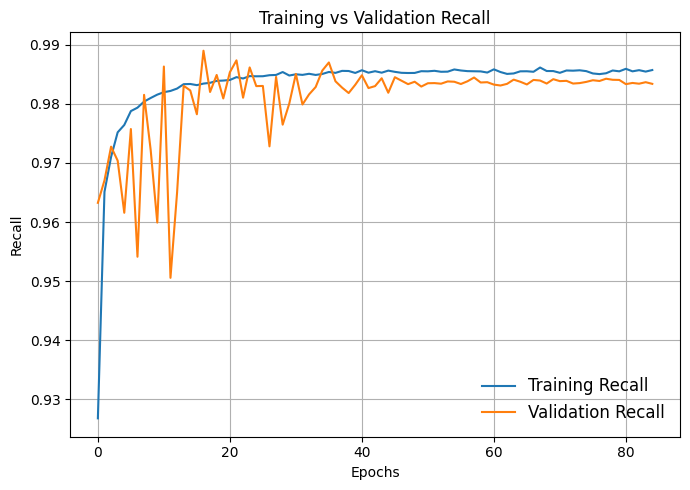

In [26]:
plt.figure(figsize=(7, 5))
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training vs Validation Precision')
plt.legend(loc = 'best', fontsize=12, frameon = False)
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{metrics_path}/training_vs_val_precision.png')
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training vs Validation Recall')
plt.legend(loc = 'best', fontsize=12, frameon = False)
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{metrics_path}/training_vs_val_recall.png')
plt.show()

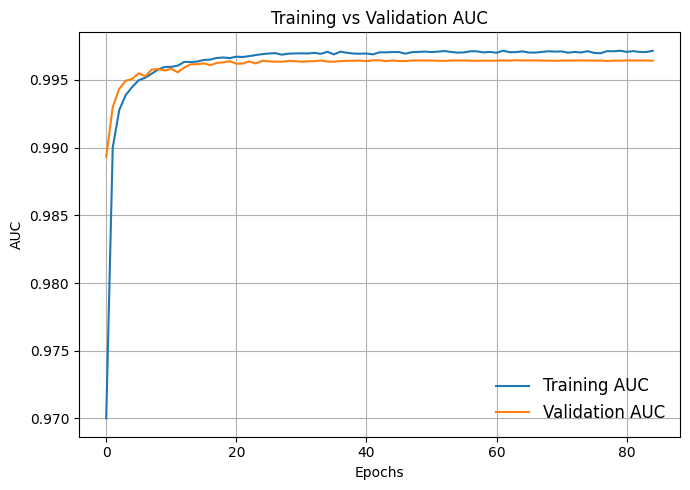

In [27]:
plt.figure(figsize=(7, 5))
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training vs Validation AUC')
plt.legend(loc = 'best', fontsize=12, frameon = False)
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{metrics_path}/training_vs_val_AUC.png')
plt.show()